<a href="https://colab.research.google.com/github/jqshang/CSC2541/blob/main/Experiments/grangernn_causal_discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jqshang/CSC2541.git
%cd CSC2541

Cloning into 'CSC2541'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 195 (delta 73), reused 133 (delta 33), pack-reused 0 (from 0)
Receiving objects: 100% (195/195), 4.07 MiB | 5.94 MiB/s, done.
Resolving deltas: 100% (73/73), done.
/content/CSC2541


In [2]:
!pip -q install MDAnalysis MDAnalysisData

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 4.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataset.syn_data import generate_synthetic_protein_data
from model.granger_nn import GrangerNeuralNet
from model.util import adjacency_to_digraph, plot_digraph, combine_position_angle_scores, print_sccs
from model.graph import filter_paths_new, build_scc_quotient_graph
from train_granger_nn import train_granger_net

In [4]:
import numpy as np
import MDAnalysis as mda
from MDAnalysisData import datasets
from MDAnalysis.analysis.dihedrals import Ramachandran

adk = datasets.fetch_adk_equilibrium()
u = mda.Universe(adk.topology, adk.trajectory)
ca = u.select_atoms("protein and name CA")

T = len(u.trajectory)
N = len(ca)
pos = np.zeros((T, N, 3))

for t, ts in enumerate(u.trajectory):
    pos[t] = ca.positions.copy()

rama = Ramachandran(ca)
rama.run()
angles = rama.angles # shape: (T, 212, 2)

rama_residues = list(rama.ag3.residues)
rama_resids = np.array([res.resid for res in rama_residues])

ca_resids = np.array([res.resid for res in ca.residues])

resid_to_index = {resid: i for i, resid in enumerate(ca_resids)}
valid_residue_indices = np.array([resid_to_index[r] for r in rama_resids])

positions = pos[:, valid_residue_indices]   # (T, 212, 3)

num_residues = len(rama_residues)    # 212
amino_acids = [f"A{i+1}" for i in range(num_residues)]  # ["A1", ..., "A212"]

label_to_residue = {
    label: {
        "index": i,
        "resid": res.resid,
        "resname": res.resname
    }
    for i, (label, res) in enumerate(zip(amino_acids, rama_residues))
}

resid_to_label = {info["resid"]: label for label, info in label_to_residue.items()}


/usr/local/lib/python3.12/dist-packages/MDAnalysisData/base.py:34: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_string
adk4AKE.psf: 795kB [00:02, 396kB/s]                           
1ake_007-nowater-core-dt240ps.dcd: 168MB [00:18, 9.30MB/s]                           
/usr/local/lib/python3.12/dist-packages/MDAnalysis/coordinates/DCD.py:171: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/usr/local/lib/python3.12/dist-packages/MDAnalysis/analysis/dihedrals.py:444: UserWarning: Cannot determine phi and psi angles for the first or last residues
 

In [5]:
# pairs = [("A1", "A16"), ("A16", "A17"), ("A17", "A30"), ("A30", "A36"), ("A30", "A16"), ("A36", "A50")]
# num_acids = 50
# num_steps = 200
# positions, angles, amino_acids = generate_synthetic_protein_data(num_acids, num_steps, pairs)

/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 50/1000 | MSE: 0.2277 | L1_v: 384.6772 | L1_t: 1923.3807
Epoch 100/1000 | MSE: 0.0663 | L1_v: 364.4550 | L1_t: 1822.2599
Epoch 150/1000 | MSE: 0.0233 | L1_v: 344.2308 | L1_t: 1721.1373
Epoch 200/1000 | MSE: 0.0114 | L1_v: 324.0055 | L1_t: 1620.0135
Epoch 250/1000 | MSE: 0.0080 | L1_v: 303.7800 | L1_t: 1518.8899
Epoch 300/1000 | MSE: 0.0066 | L1_v: 283.5546 | L1_t: 1417.7666
Epoch 350/1000 | MSE: 0.0070 | L1_v: 263.3297 | L1_t: 1316.6433
Epoch 400/1000 | MSE: 0.0071 | L1_v: 243.1051 | L1_t: 1215.5204
Epoch 450/1000 | MSE: 0.0070 | L1_v: 222.8812 | L1_t: 1114.3981
Epoch 500/1000 | MSE: 0.0076 | L1_v: 202.6581 | L1_t: 1013.2764
Epoch 550/1000 | MSE: 0.0082 | L1_v: 182.4361 | L1_t: 912.1561
Epoch 600/1000 | MSE: 0.0097 | L1_v: 162.2156 | L1_t: 811.0373
Epoch 650/1000 | MSE: 0.0128 | L1_v: 141.9975 | L1_t: 709.9209
Epoch 700/1000 | MSE: 0.0200 | L1_v: 121.7834 | L1_t: 608.8085
Epoch 750/1000 | MSE: 0.0357 | L1_v: 101.5757 | L1_t: 507.7027
Epoch 800/1000 | MSE: 0.0688 | L1_v: 81.3787 |

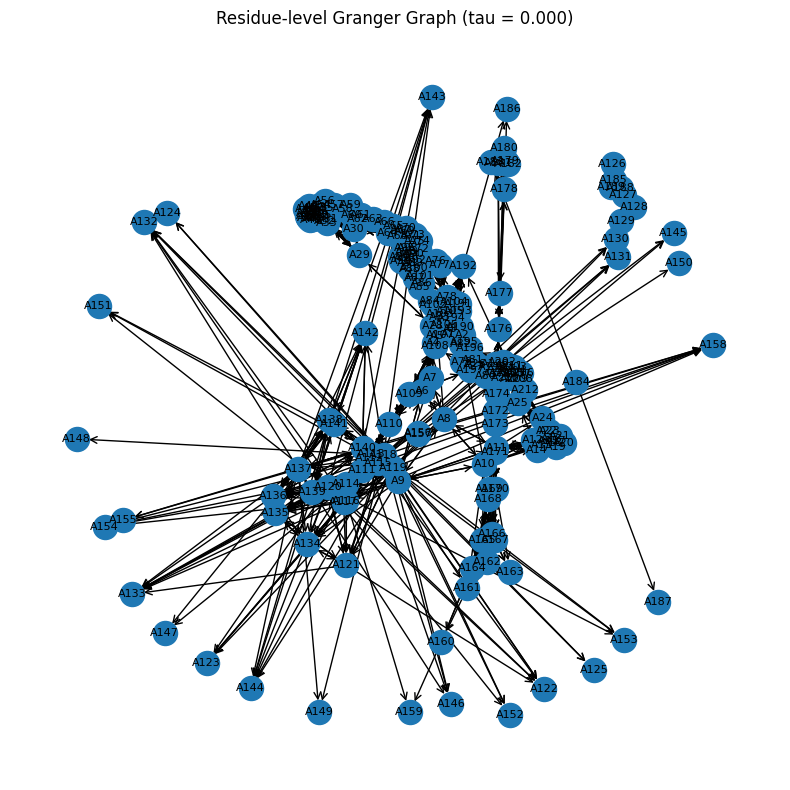

In [5]:
G_res_position, tau_position, S_res_position = train_granger_net(positions, n_epochs=1000)
DG_res_position = adjacency_to_digraph(G_res_position,node_names=amino_acids)
plot_title = f"Residue-level Granger Graph (tau = {tau_position:.3f})"
plot_digraph(DG_res_position, node_names=amino_acids, title=plot_title)

/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 50/1000 | MSE: 0.0035 | L1_v: 170.9666 | L1_t: 854.8349
Epoch 100/1000 | MSE: 0.0001 | L1_v: 161.9737 | L1_t: 809.8871
Epoch 150/1000 | MSE: 0.0001 | L1_v: 152.9826 | L1_t: 764.9412
Epoch 200/1000 | MSE: 0.0001 | L1_v: 143.9922 | L1_t: 719.9958
Epoch 250/1000 | MSE: 0.0001 | L1_v: 135.0023 | L1_t: 675.0511
Epoch 300/1000 | MSE: 0.0001 | L1_v: 126.0127 | L1_t: 630.1071
Epoch 350/1000 | MSE: 0.0001 | L1_v: 117.0233 | L1_t: 585.1634
Epoch 400/1000 | MSE: 0.0001 | L1_v: 108.0341 | L1_t: 540.2200
Epoch 450/1000 | MSE: 0.0001 | L1_v: 99.0453 | L1_t: 495.2765
Epoch 500/1000 | MSE: 0.0002 | L1_v: 90.0568 | L1_t: 450.3331
Epoch 550/1000 | MSE: 0.0003 | L1_v: 81.0688 | L1_t: 405.3904
Epoch 600/1000 | MSE: 0.0006 | L1_v: 72.0818 | L1_t: 360.4486
Epoch 650/1000 | MSE: 0.0012 | L1_v: 63.0964 | L1_t: 315.5084
Epoch 700/1000 | MSE: 0.0028 | L1_v: 54.1141 | L1_t: 270.5713
Epoch 750/1000 | MSE: 0.0075 | L1_v: 45.1380 | L1_t: 225.6404
Epoch 800/1000 | MSE: 0.0241 | L1_v: 36.1760 | L1_t: 180.7236
E

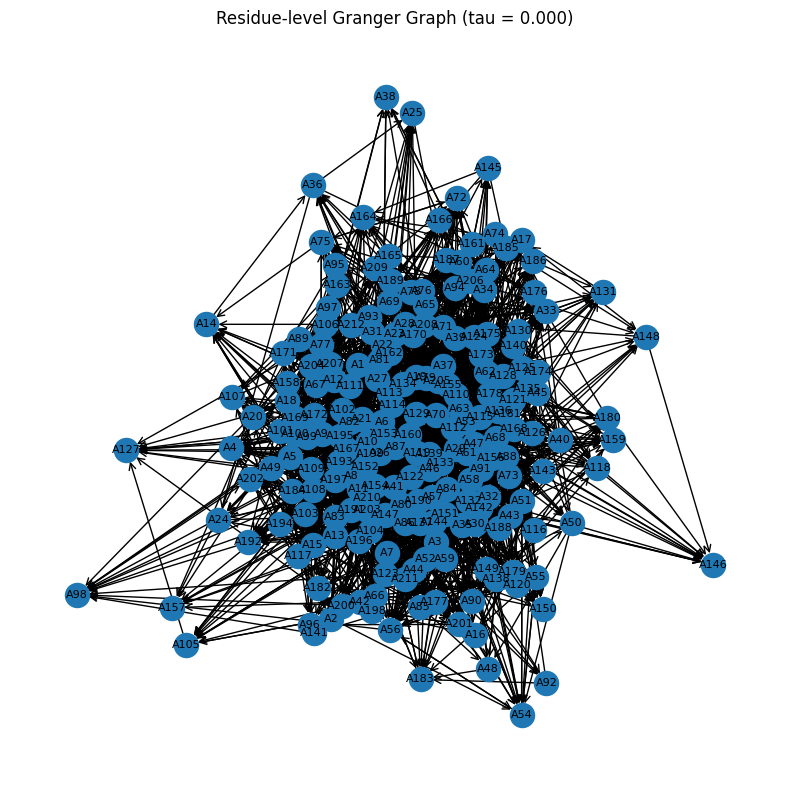

In [6]:
G_res_angle, tau_angle, S_res_angle = train_granger_net(angles, n_epochs=1000)
DG_res_angle = adjacency_to_digraph(G_res_angle, node_names=amino_acids)
plot_title = f"Residue-level Granger Graph (tau = {tau_angle:.3f})"
plot_digraph(DG_res_angle, node_names=amino_acids, title=plot_title)

Combined threshold (tau_comb): 0.0017620627
Number of residue edges in combined graph: 2043


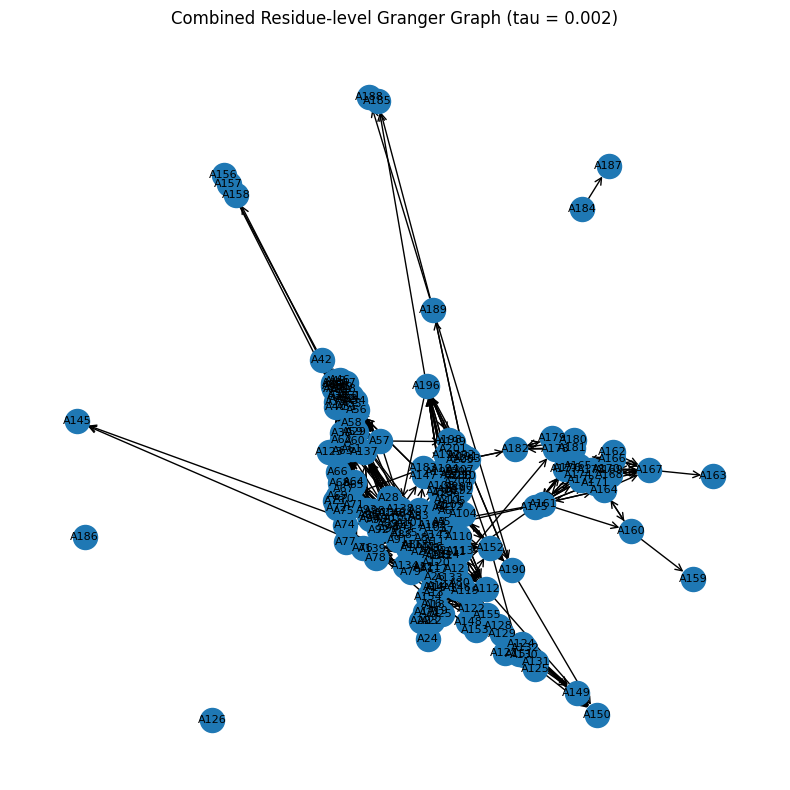

In [7]:
G_res_comb, tau_comb, S_res_comb = combine_position_angle_scores(S_res_position, S_res_angle)
print("Combined threshold (tau_comb):", tau_comb)
print("Number of residue edges in combined graph:", G_res_comb.sum())

DG_res_comb = adjacency_to_digraph(G_res_comb, node_names=amino_acids)
plot_title = f"Combined Residue-level Granger Graph (tau = {tau_comb:.3f})"
plot_digraph(DG_res_comb, node_names=amino_acids, title=plot_title)

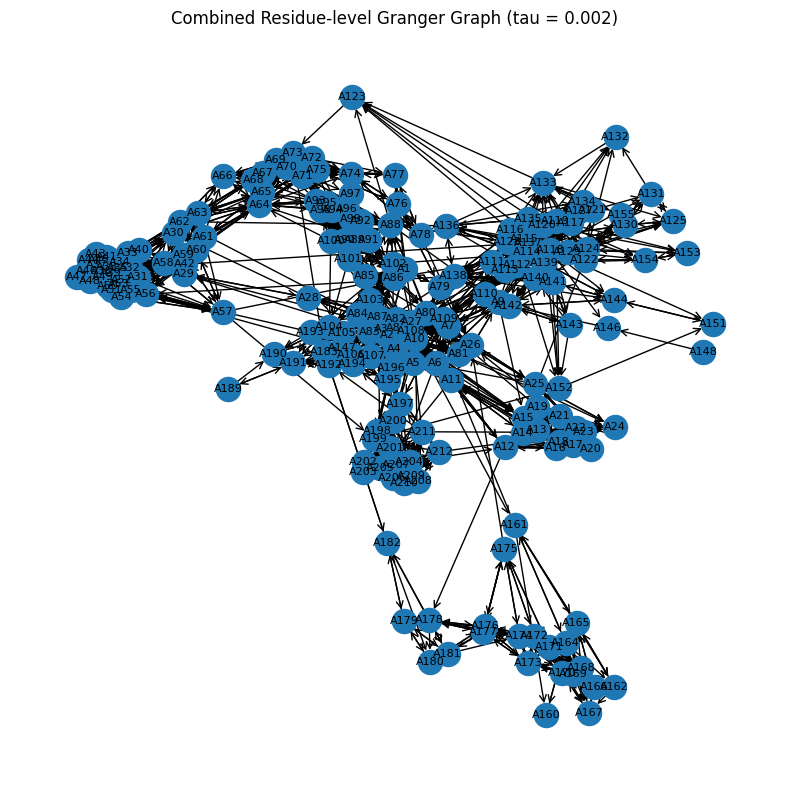

In [8]:
# assuming plot_digraph(DG, node_names, title) is already defined

allosteric_sites = [f"A{i}" for i in range(120, 158)]
active_sites = [f"A{i}" for i in range(28, 58)]

DG_signal, used_nodes, used_edges = filter_paths_new(
    DG_res_comb,
    amino_acids,
    allosteric_sites,
    active_sites,
)

# plot_title = f"Signaling pathways {allosteric_sites} → {active_sites}"
plot_digraph(DG_signal, node_names=amino_acids, title=plot_title)

Strongly connected components (SCCs):
  SCC 0: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, A15, A16, A17, A18, A19, A20, A21, A22, A23, A24, A25, A26, A27, A28, A29, A30, A31, A32, A33, A34, A35, A36, A37, A38, A39, A40, A41, A42, A43, A44, A45, A46, A47, A48, A49, A50, A51, A52, A53, A54, A55, A56, A57, A58, A59, A60, A61, A62, A63, A64, A65, A66, A67, A68, A69, A70, A71, A72, A73, A74, A75, A76, A77, A78, A79, A80, A81, A82, A83, A84, A85, A86, A87, A88, A89, A90, A91, A92, A93, A94, A95, A96, A97, A98, A99, A100, A101, A102, A103, A104, A105, A106, A107, A108, A109, A110, A111, A112, A113, A114, A115, A116, A117, A118, A119, A120, A121, A122, A123, A124, A125, A127, A128, A129, A130, A131, A132, A133, A134, A135, A136, A137, A138, A139, A140, A141, A142, A143, A144, A146, A147, A151, A152, A153, A154, A155, A160, A161, A162, A164, A165, A166, A167, A168, A169, A170, A171, A172, A173, A174, A175, A176, A177, A178, A179, A180, A181, A182, A183, A189, A190, A191, A192,

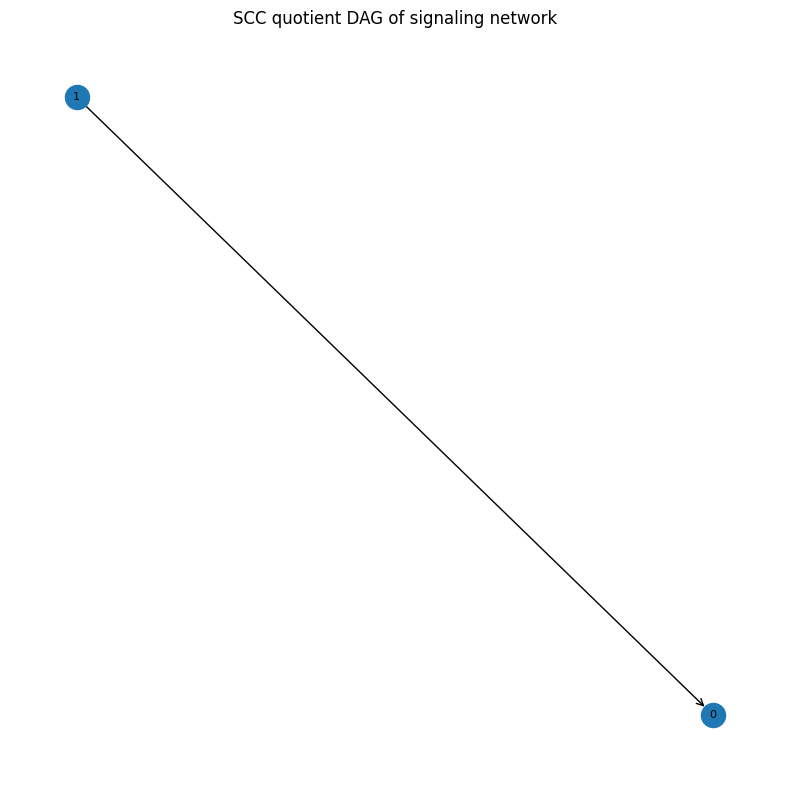

In [9]:
sccs, node_to_scc, Q = build_scc_quotient_graph(DG_signal, amino_acids)

print_sccs(sccs, amino_acids)

plot_title = "SCC quotient DAG of signaling network"
plot_digraph(Q, title=plot_title)

In [ ]:
sccs, node_to_scc, Q = build_scc_quotient_graph(DG_signal, amino_acids)

print_sccs(sccs, amino_acids)

plot_title = "SCC quotient DAG of signaling network"
plot_digraph(Q, title=plot_title)